In [2]:
from endplay.types import Deal, Contract, Denom, Vul, Player, Card
from endplay.dealer import generate_deal
from endplay.dds.ddtable import calc_dd_table
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute costs/rewards with dd

In [145]:
def random_two_hands():
    d = generate_deal()
    return d.north, d.south

def random_remaining_hands(north, south):
    d = Deal()
    d.north, d.south = north, south
    return generate_deal(predeal=d)

def tricks_dd(d):
    return calc_dd_table(d)

def tricks_tb_to_score(tricks):
    scores = {Player.north: [0], Player.south: [0]}
    for c in [Contract(level = l, denom = d, declarer=dc) 
                for l in range(1,8) 
                for d in [Denom.clubs, Denom.diamonds, Denom.hearts, Denom.spades, Denom.nt]
                for dc in [Player.north, Player.south]]:
        c.result = tricks[c.declarer,c.denom] - (c.level + 6)
        scores[c.declarer].append(c.score(Vul.none))

    scores[Player.north], scores[Player.south] =\
          np.array(scores[Player.north]), np.array(scores[Player.north])
    return scores


def mean_scores(north, south, N=5):
    deals = [random_remaining_hands(north, south) for _ in range(N)]
    score_results = [tricks_tb_to_score(tricks_dd(d))
                   for d in deals]
    score_means = {}
    for p in [Player.north, Player.south]:
        score_means[p] = np.mean(np.concat([r[p].reshape(1,-1) for r in score_results], axis = 0),
                                axis = 0)
    return score_means


def score_to_imp(diff):
    assert diff >= 0
    imp_table = [
        (0,0), (20, 1), (50, 2), (90, 3), (130, 4), (170, 5), (220, 6),
        (260, 7), (310, 8), (360, 9), (420, 10), (490, 11), (590, 12),
        (740, 13), (890, 14), (1090, 15), (1290, 16), (1490, 17), (1740, 18),
        (1990, 19), (2240, 20), (2490, 21), (2990, 22), (3490, 23), (3990, 24)
    ]
    
    for threshold, imp in imp_table:
        if diff <= threshold:
            return imp
    return 24


def costs_imp(scores):
    costs = {}
    for p in [Player.north, Player.south]:
        costs[p] = np.array([score_to_imp(diff) 
                             for diff in np.max(scores[p]) - scores[p]])
    return costs


def reward_from_cost(imps):
    rewards = {}
    for p in [Player.north, Player.south]:
        rewards[p] = 1 - (imps[p] - np.min(imps[p]))/25
    return rewards

In [146]:
north, south = random_two_hands()
d = random_remaining_hands(north, south)
north.pprint()
south.pprint()
d.pprint()

♠ JT54
♥ J654
♦ K64
♣ Q2
♠ 63
♥ KT3
♦ J95
♣ AT964
              JT54
              J654
              K64
              Q2
K7                          AQ982
AQ872                       9
AQT32                       87
8                           KJ753
              63
              KT3
              J95
              AT964


In [147]:
tricks = tricks_dd(d)
tricks.pprint()

     ♣  ♦  ♥  ♠ NT
  N  4  2  4  3  3
  S  4  2  4  2  4
  E  9 10  9 10  9
  W  8 10  9 10  9


In [148]:
tricks_tb_to_score(tricks_dd(d))

{<Player.north: 0>: array([   0, -150, -250, -150, -200, -200, -200, -300, -200, -250, -250,
        -250, -350, -250, -300, -300, -300, -400, -300, -350, -350, -350,
        -450, -350, -400, -400, -400, -500, -400, -450, -450, -450, -550,
        -450, -500, -500]),
 <Player.south: 2>: array([   0, -150, -250, -150, -200, -200, -200, -300, -200, -250, -250,
        -250, -350, -250, -300, -300, -300, -400, -300, -350, -350, -350,
        -450, -350, -400, -400, -400, -500, -400, -450, -450, -450, -550,
        -450, -500, -500])}

In [149]:
scores = mean_scores(north, south)
scores

{<Player.north: 0>: array([   0.,  -90., -190., -130., -190., -150., -140., -240., -180.,
        -240., -200., -190., -290., -230., -290., -250., -240., -340.,
        -280., -340., -300., -290., -390., -330., -390., -350., -340.,
        -440., -380., -440., -400., -390., -490., -430., -490., -450.]),
 <Player.south: 2>: array([   0.,  -90., -190., -130., -190., -150., -140., -240., -180.,
        -240., -200., -190., -290., -230., -290., -250., -240., -340.,
        -280., -340., -300., -290., -390., -330., -390., -350., -340.,
        -440., -380., -440., -400., -390., -490., -430., -490., -450.])}

In [150]:
costs = costs_imp(scores)
costs

{<Player.north: 0>: array([ 0,  3,  6,  4,  6,  5,  5,  7,  6,  7,  6,  6,  8,  7,  8,  7,  7,
         9,  8,  9,  8,  8, 10,  9, 10,  9,  9, 11, 10, 11, 10, 10, 11, 11,
        11, 11]),
 <Player.south: 2>: array([ 0,  3,  6,  4,  6,  5,  5,  7,  6,  7,  6,  6,  8,  7,  8,  7,  7,
         9,  8,  9,  8,  8, 10,  9, 10,  9,  9, 11, 10, 11, 10, 10, 11, 11,
        11, 11])}

In [151]:
reward_from_cost(costs)

{<Player.north: 0>: array([1.  , 0.88, 0.76, 0.84, 0.76, 0.8 , 0.8 , 0.72, 0.76, 0.72, 0.76,
        0.76, 0.68, 0.72, 0.68, 0.72, 0.72, 0.64, 0.68, 0.64, 0.68, 0.68,
        0.6 , 0.64, 0.6 , 0.64, 0.64, 0.56, 0.6 , 0.56, 0.6 , 0.6 , 0.56,
        0.56, 0.56, 0.56]),
 <Player.south: 2>: array([1.  , 0.88, 0.76, 0.84, 0.76, 0.8 , 0.8 , 0.72, 0.76, 0.72, 0.76,
        0.76, 0.68, 0.72, 0.68, 0.72, 0.72, 0.64, 0.68, 0.64, 0.68, 0.68,
        0.6 , 0.64, 0.6 , 0.64, 0.64, 0.56, 0.6 , 0.56, 0.6 , 0.6 , 0.56,
        0.56, 0.56, 0.56])}

# One-hot encoded hands

In [153]:
north, south = random_two_hands()
north.pprint()
print()
south.pprint()

♠ AKQ5
♥ AQ7532
♦ J8
♣ 5

♠ J3
♥ T8
♦ AKT6
♣ KQ987


In [ ]:
def one_hot_hands(hand):
    cards_index = {Card(name = f"{denom}{rank}"): i 
                    for i, (denom, rank) in enumerate((d, r) for d in ["C", "D", "H", "S"]\
                                                           for r in [2, 3, 4, 5, 6, 7, 8, 9, "T", "J", "Q", "K", "A"])}
    ohe = np.zeros(52)

    for card in hand:
        ohe[cards_index[card]] = 1
    return ohe

In [201]:
one_hot_hands(north), one_hot_hands(south)

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1.]),
 array([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.]))

# Save dataset

In [17]:
import tools as tools

In [81]:
for slice in range(100,131):
    print(slice)
    tools.generate_df(1000).to_csv(f"data/slice{slice}.csv")

100


100%|██████████| 1000/1000 [20:07<00:00,  1.21s/it]


101


100%|██████████| 1000/1000 [18:31<00:00,  1.11s/it]


102


100%|██████████| 1000/1000 [18:49<00:00,  1.13s/it]


103


100%|██████████| 1000/1000 [16:24<00:00,  1.02it/s]


104


100%|██████████| 1000/1000 [19:01<00:00,  1.14s/it]


105


100%|██████████| 1000/1000 [21:01<00:00,  1.26s/it] 


106


100%|██████████| 1000/1000 [18:02<00:00,  1.08s/it]


107


100%|██████████| 1000/1000 [17:09<00:00,  1.03s/it]


108


100%|██████████| 1000/1000 [16:49<00:00,  1.01s/it]


109


100%|██████████| 1000/1000 [14:57<00:00,  1.11it/s]


110


100%|██████████| 1000/1000 [17:26<00:00,  1.05s/it]


111


100%|██████████| 1000/1000 [16:23<00:00,  1.02it/s]


112


100%|██████████| 1000/1000 [14:57<00:00,  1.11it/s]


113


100%|██████████| 1000/1000 [15:29<00:00,  1.08it/s]


114


100%|██████████| 1000/1000 [15:54<00:00,  1.05it/s]


115


100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s]


116


100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s]


117


100%|██████████| 1000/1000 [15:48<00:00,  1.05it/s] 


118


100%|██████████| 1000/1000 [14:58<00:00,  1.11it/s]


119


100%|██████████| 1000/1000 [15:08<00:00,  1.10it/s]


120


100%|██████████| 1000/1000 [14:31<00:00,  1.15it/s]


121


100%|██████████| 1000/1000 [16:26<00:00,  1.01it/s]


122


100%|██████████| 1000/1000 [19:38<00:00,  1.18s/it]


123


100%|██████████| 1000/1000 [18:17<00:00,  1.10s/it]


124


100%|██████████| 1000/1000 [19:20<00:00,  1.16s/it] 


125


100%|██████████| 1000/1000 [18:17<00:00,  1.10s/it]


126


100%|██████████| 1000/1000 [18:31<00:00,  1.11s/it]


127


100%|██████████| 1000/1000 [18:24<00:00,  1.10s/it]


128


100%|██████████| 1000/1000 [17:36<00:00,  1.06s/it]


129


100%|██████████| 1000/1000 [17:35<00:00,  1.06s/it]


130


100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s]


In [4]:
r_list = []
for slice in range(14):
    r_list.append(np.array(pd.read_csv(f"data/slice{slice}.csv", index_col = 0).iloc[:,104:]).flatten())
rewards = np.concatenate(r_list)
rewards.shape

(10080000,)

In [9]:
r, counts = np.unique(rewards, return_counts = True)
counts = counts / 100000

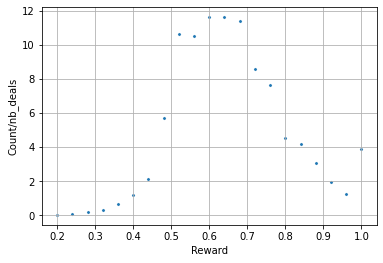

In [10]:
sns.scatterplot(x = r, y = counts,s=10)
plt.xlabel("Reward")
plt.ylabel("Count/nb_deals")
plt.grid()